# TEDS End-to-End Simulation for TANGO-Carbon for exact detector drawing, binning 5

#### This notebook includes a full-chain processing pipeline for TANGO Carbon. The chain is setup for consistent processing that is outlined in the following diagram:  

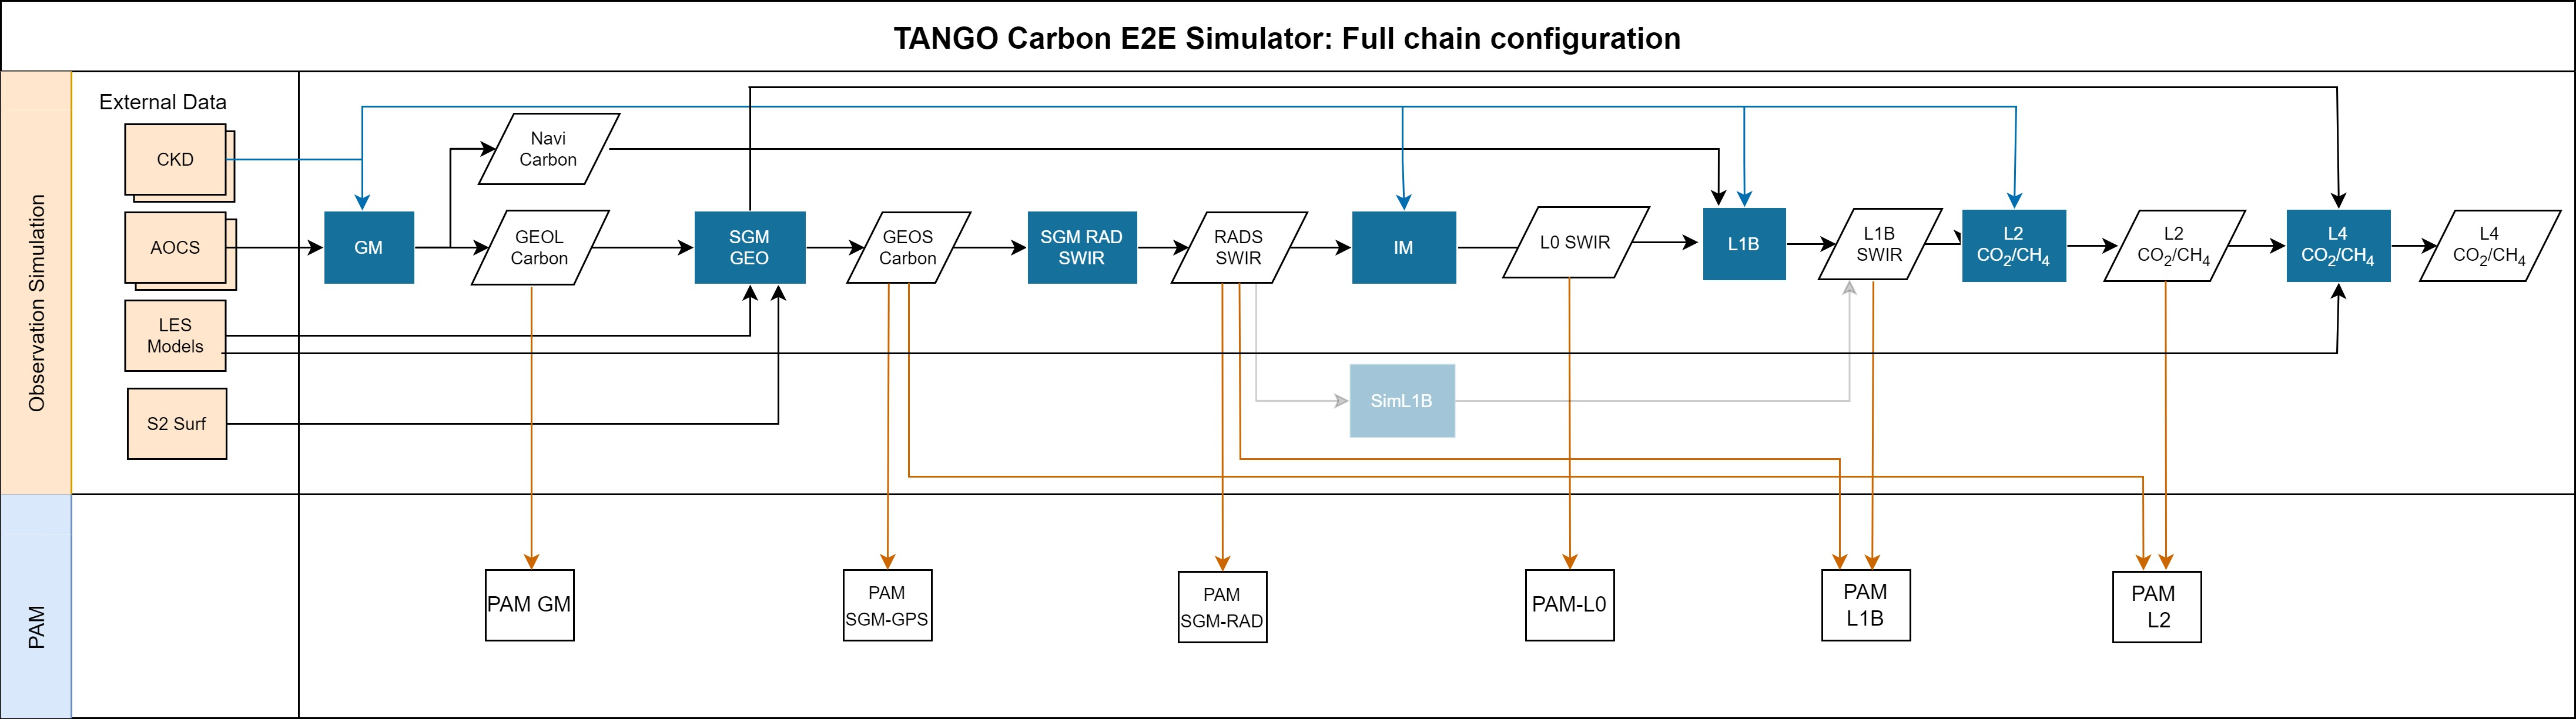

The Notebook has two main objectives:
1. Demonstrate the design of TEDS and how the modules can be used to setup an end-to-end analysis. Depending on the objectives different configurations can be used, which are illustrated by different notebooks. 
2. The Notebook also shows that linear propagation of L1B abd L2 precision is a valid approach for the chosen scenario.

The notebook includes visualization tools (PAM tools) to allow analysis of the results. We note that the PAM libary cannot be complete in the sense that ot provides all possible tools for data analysis. We advise Python experienced uses to analyse the data with the manifold of Python data analysis tools as provided by e.g. the mathplotloib libray.     

Remark: All binning/detector drawing specific settings are given in the notebook and overwrites the settings from the yaml files. 

## Reference
+ Laasner R., Landgraf, J., Borsdorff, T., Leune, B., van Amelrooy, E., van Hoek, M., Ludewig, A., Veefkind P.: Algorithm Theoretical Baseline Document for TANGO End-to-End Simulator, SRON-ESG-TN-2022-012, TANGO Mission Consortium, The Netherlands, 2024
+ Developers manual <a href="https://teds.rtfd.io/"> online document</a>

## 1. Initialization

We setup and configure the overall notebook. This does not include the specific configuration of the individual modules. To this end, check the YAML configuration files in the settings directory. 

#### 2.1 Setup the working environment

In [1]:
import sys
import os
import yaml

# define  path to search for module
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp1_full_chain/")

#### 1.2 Import TEDS modules

In [2]:
from teds.gm.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.sgm import Carbon_radiation_scene_generation
from teds.im import run_instrument_model
from teds.l1al1b import run_l1al1b
from teds.siml1b import simplified_instrument_model_and_l1b_processor
from teds.l1l2.l1bl2 import level1b_to_level2_processor
from teds.l2l4 import level2_to_level4_processor          
from teds.pam import pam_co2

#### 1.3 Select the target scene named after the targeted power plant 
Currently, four reference scenes can be used: (1) Matimba, (2) Jenschwalde, (3) Belchatow, (4) Lipetsk. The settings is needed to configure GM (orbit) and SGM.


In [3]:
#station_name = 'Matimba'
station_name = 'Jaenschwalde'
#station_name = 'Belchatow'
#station_name = 'Lipetsk'

### 1.4 Configure specific run
All module interfaces are file-based. So, all modules can be called as 'stand-alone' if the required input files exist. Note that you might to run low level modules to generate the input. PM modules can be also used as 'stand-alone' for data analysis.

In [4]:
proc_gm     = True; pam_gm     = True
proc_sgmgeo = True; pam_sgmgeo = True
proc_sgmrad = True; pam_sgmrad = True
proc_im     = True; pam_im     = True
proc_l1al1b = True; pam_l1b    = True
proc_siml1b = True
proc_l1bl2  = True;  pam_l2    = True
proc_l4     = True

## 2. Geometry Model

#### 2.1 Run the GM module
The *gm_config_station* yaml-file contains the orbit and sensor configuration to simulate the overpass over the specified target area (station_name). All other configuration parameter for the GM module are given in the *gm_config* file.  

In [ ]:
if(proc_gm):
    #configureation file
    gm_config   = yaml.safe_load(open('./settings/gm_config.yaml'))
    gm_stations = yaml.safe_load(open('./settings/gm_station_parameter.yaml'))
    #select orbit and sensor data  for the selected target
    gm_config['orbit'] = gm_stations[station_name]['orbit']
    gm_config['sensor'] = gm_stations[station_name]['sensor']

    #For Jaenschwalde, reduce sensing time interval to reduce also internal memory usse.
    gm_config['sensor']['start_time']= 13.760 # minutes wrt orbit epoch
    gm_config['sensor']['end_time']  = 13.775 # minutes wrt orbit epoch

    #use ACT100 ckd input
    gm_config['io_files']['ckd'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/ckd/ckd_ACT100_20250126.nc'

    geometry_module(gm_config)

#### 2.2 Visualization of the GM output

Use plt_options=*'geoloc'*  to show the geolocation of the pixel center points, and plt_options=*'geometry'*  to show solar zenith angle, sensor zenith angle, solar azimuth angle, and sensor azimuth angle.

In [ ]:
if(pam_gm):
    gm_config= yaml.safe_load(open('./settings/gm_config.yaml'))
    filen = gm_config['io_files']['geometry']
    plt_option = 'geoloc'
    #plt_option = 'geometry'
    pam_co2.pam_gm_Tango_Carbon(filen, station_name, plt_option)

## 3. Scene Generatior Module (SGM): Geo-Physical Scene

### 3.1 Run the SGM-GEO module
This module provides the model atmosphere and the surface properties for the allocated scene. 

In [ ]:
if(proc_sgmgeo):
    sgmgeo_stations= yaml.safe_load(open('./settings/geosgm_station_parameter.yaml'))
    sgmgeo_config= yaml.safe_load(open('./settings/geosgm_config.yaml'))
    #adjust target specific configs
    sgmgeo_config['io_files']['input_s2'] = sgmgeo_stations[station_name]['input_s2']
    sgmgeo_config['io_files']['meteo'] = sgmgeo_stations[station_name]['meteo']

    geoscene_generation(sgmgeo_config)

### 3.2 Vizualization of SGM-GEO output

plt_options is used to configure the output. 
* The input 'albedo Bxx' specifies the spectral band to be plotted. Here, xx is the band specification. Only bands can be plotted that are given in the input data (e.g. B08 is not available but the more norrow band B08A can be plotted). 
* The input 'Xxx' specifies the trace gas. Here, xx can be CO2, NO, NO2, CH4, or H2O

In [ ]:
if(pam_sgmgeo):
    sgmgeo_config= yaml.safe_load(open('./settings/geosgm_config.yaml'))
    filen = sgmgeo_config['io_files']['output_geo']
    plt_option = 'XCO2'
    #plt_option = 'albedo B11'
    pam_co2.pam_sgm_gps(filen, station_name, plt_option)

## 4. Scene Generator Module (SGM): Radiation Scene

### 4.1 Run SGM-RAD module to generate the radiometric scene
A line-by-line spectrum is simulated for each pixel with the geometry given by the GM and with the model atmosphere specfied by the SGM-GEO. 

In [ ]:
if(proc_sgmrad):
    sgmrad_config= yaml.safe_load(open('./settings/radsgm_config.yaml'))
    sgmrad_config['binning_act']=1
    sgmrad_config['kernel_parameter']['fwhm_x']=300
    Carbon_radiation_scene_generation(sgmrad_config)

### 4.2 PAM Visualization of radiometric scene
Two panels are created. First a map of the radiometric scene for the wavelength wavel. On this map up to four pixels can be chosen using the tuple ialt_iact. The corresponding spectra are dipicted in the right panel. Indices *ialt, iact* must be within the GM domain!

In [ ]:
if(pam_sgmrad):
    sgmrad_config= yaml.safe_load(open('./settings/radsgm_config.yaml'))
    filen_rad = sgmrad_config['io_files']['output_rad']
    wavel = 1600.0
    ialt_iact = [[5, 50], [10,40], [3, 80]]
    pam_co2.pam_sgm_rad(filen_rad, station_name, wavel, ialt_iact)

## 5. Instrument Model (IM)

The instrument model uses instrument Calibration Key Data (CKD) to simulate instrument detector images.

### 5.1 Run the IM

In [ ]:
if(proc_im):
    im_config = yaml.safe_load(open('./settings/im_config.yaml'))
    im_config['io']['ckd']= '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/ckd/ckd_ACT100_20250126.nc'
    im_config['swath']['exact_drawing'] = True
    im_config['detector']['binning_table_id'] = 5
    run_instrument_model(im_config)

### 5.2 PAM Plotting detector images

The generated L0 data contain a series of detector images. The index ialt points to the image.

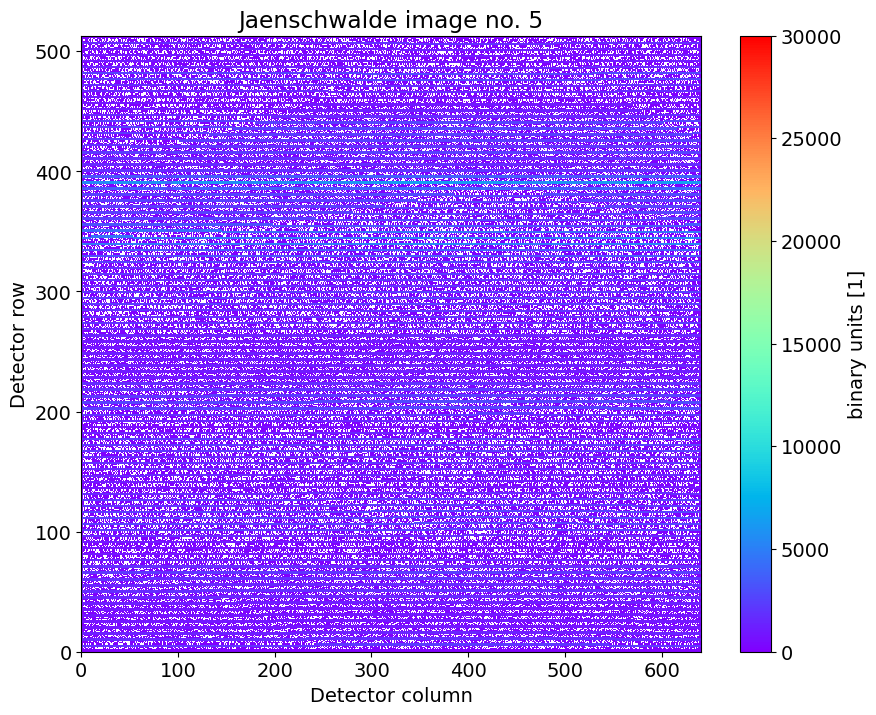

In [5]:
if(pam_im):
    im_config= yaml.safe_load(open('./settings/im_config.yaml'))
    filen_rad = im_config['io']['l1a']
    ialt = 5
    title = station_name + f' image no. {ialt}'
    data_max = 30000.
    pam_co2.pam_im(filen_rad, ialt, data_max, title)

## 6. L1A to L1B Processor (PDGS element)

We skip the L0-L1A proccessor as it has no effect on performance analysis. (As part of the PDGS, the L0-L1A processor is relevant for a smooth data flow.) Here, we inject directly navigation data and level o data into the L1A-L1B processor. This processor is a beta version for the Payload Data Ground Segement. Its main task is to calibrate the simulated detector images and to derive geolocation from the navigation data. 

For the processing of L1B we consider two options:
+ The full processing chain using the instrument CKDs. This option is particular interesting for performance analysis and specific CKD analyses. 
+ The simplified L1B processor. Without using the IM, this tool simulates the L1B product directly from the SGM data using a spectral convolution of the line-by-line spectra and a simplified SNR model.

### 6.1 Execute L1A-L1B data processing

The L1A-L1B processor is setup to be the 'inverse' operation of the IM. This allows a direct comparision of the L1B product with convolved SGM-RAD spectra (see PAM module).

In [6]:
if(proc_l1al1b):
    l1al1b_config= yaml.safe_load(open('./settings/l1al1b_config.yaml'))
    l1al1b_config['io']['ckd'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/ckd/ckd_ACT100_20250126.nc'
    l1al1b_config['swath']['exact_drawing'] = True
    l1al1b_config['bin_spectra']= 5   #in combination with extract_drawing=True this adjusts SNR only.
    run_l1al1b(l1al1b_config)

[22:13:09] Processing from L1A to L1B
[22:13:09] Reading input data


#######################
# Tango L1B processor #
#######################
Version                 : 0.0.1
Commit hash             : 6afe7ff4
Date and timezone       : 2025 February 08 Sat
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic

##############################
# Reading CKD and input data #
##############################


[22:13:10] Coadding and binning
[22:13:10] Noise
[22:13:10] Nonlinearity



#############
# Retrieval #
#############


100%|██████████| 21/21 [00:00<00:00, 26.87it/s]
[22:13:11] Smoothing over bad values
100%|██████████| 21/21 [00:01<00:00, 10.90it/s]
[22:13:15] Mapping from detector
100%|██████████| 21/21 [00:04<00:00,  4.47it/s]
[22:13:20] Radiometric
[22:13:20] Writing output data



###########
# Success #
###########


### 6.2 Simplified L1B generator

For some studies, it makes sense to replace the IM and the L1A-L1B processor by a simple L1B generator that simulates a L1B product from the SGM simulations. It applies a spectral convolution and a two-parameter SNR model to the spectra and allocates the GM geolocation to the data product.
$$
SNR = \frac{ a I_{conv}}{\sqrt{ a I_{conv} +b}}
$$ 
with the coefficients $a$ describing shot noise and $b$ given the signal independent noise contribution. The $a$ and $b$ coefficients are considered to be external input like CKD.

In [ ]:
if(proc_siml1b):
    siml1b_config= yaml.safe_load(open('./settings/siml1b_config.yaml'))
    siml1b_config['binning_act'] = 1
    simplified_instrument_model_and_l1b_processor(siml1b_config)

### 6.3 PAM Comparision with SGM-RAD output

For the exact drawing algorithm, we can compare the generated L1B with the SGM input. For this purpose, the SGM-RAD spectra are convolved with the ISRF. Two plotting options exist: 

+ *plt_options = spectrum* compares individual spectra. It requires as input the *ialt* and *iact* indices to select the spectrum. Check that the ISRF is configured correctly. 
+ *plt_options = histo* generates a histogram of the normalized radiance error
$$
\frac{I_{L1b}(\lambda) -I_{ref}(\lambda)}{\sigma(\lambda)}
$$ 
for all spectra. A correct unbiased processing yields a normal distribution with a standard deviation of 1 and a mean of 0.
When using the simplified L1B data, test becomes trival and checks the radom generation of noise in simL1B.

In [ ]:
if(pam_l1b):
    siml1b_config= yaml.safe_load(open('./settings/siml1b_config.yaml'))
    #filen_l1b = siml1b_config['io_files']['output_l1b']

    l1al1b_config= yaml.safe_load(open('./settings/l1al1b_config.yaml'))
    filen_l1b = l1al1b_config['io']['l1b']

    filen_sgmrad = siml1b_config['io_files']['input_sgm']
    isrf_config={}
    isrf_config['type'] = 'Gaussian'  #type of ISRF, currently only Gaussian or generalized_normal
    isrf_config['fwhm'] = 0.45        #fwhm [nm]
    plt_options = 'spectrum'
    ialt,iact =(1,35)                 #onoly needed in case of plt_options = spectrum
    plt_options  = 'histo'
    err_bounds   = [-4,4]             #error bounds for histogram analysis (remove outliers), must be symmetric
    spec_nominal = False              #True means plotting only nominal spectral range [1590-1675]
    pam_co2.pam_l1b(filen_l1b, 
                    filen_sgmrad, 
                    isrf_config, 
                    plt_options, 
                    ialt, 
                    iact, 
                    spec_nominal, 
                    err_bounds)

## 7. Level 1B to Level 2 $\rm CO_2$ and $\rm CH_4$ Proxy Retrieval

### 7.1 L2 processing of the $\mathrm{CO_2}$ and $\mathrm{CH_4}$ proxy product

The CO2/CH4 retrieval algorithm is based on a profile scaling approach and so fits the columns of CO2 and CH4 using a non-scattering RTM. Using these intermediate products, the proxy product XCO2 and XCH4 is drived.  

In [7]:
if(proc_l1bl2):
    l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
    level1b_to_level2_processor(l1bl2_config)

level 1B to 2 proessor ...


100%|██████████| 21/21 [34:03<00:00, 97.29s/it] 

/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp1.0.nc
diag_output
=> l1bl2 finished successfully


### 7.2 PAM L2 comparision with SGM-GEO reference
Again, the PAM has two options:
+ plt_options = 'map' creates a map of the retrieved $XCO2$ and its precision $\sigma(XCO_2)$ for the data granule.
+ plt_options = 'histo' creates a histogram of all spatial samples of the normalized L2 error:
$$
\mathrm{\frac{XCO_{2}^{ret} -XCO_2^{sgm}}{\sigma(XCO_2)}}
$$ 
An unbiased processing yields a normal distribution with a standard deviation of 1 and a mean of 0.

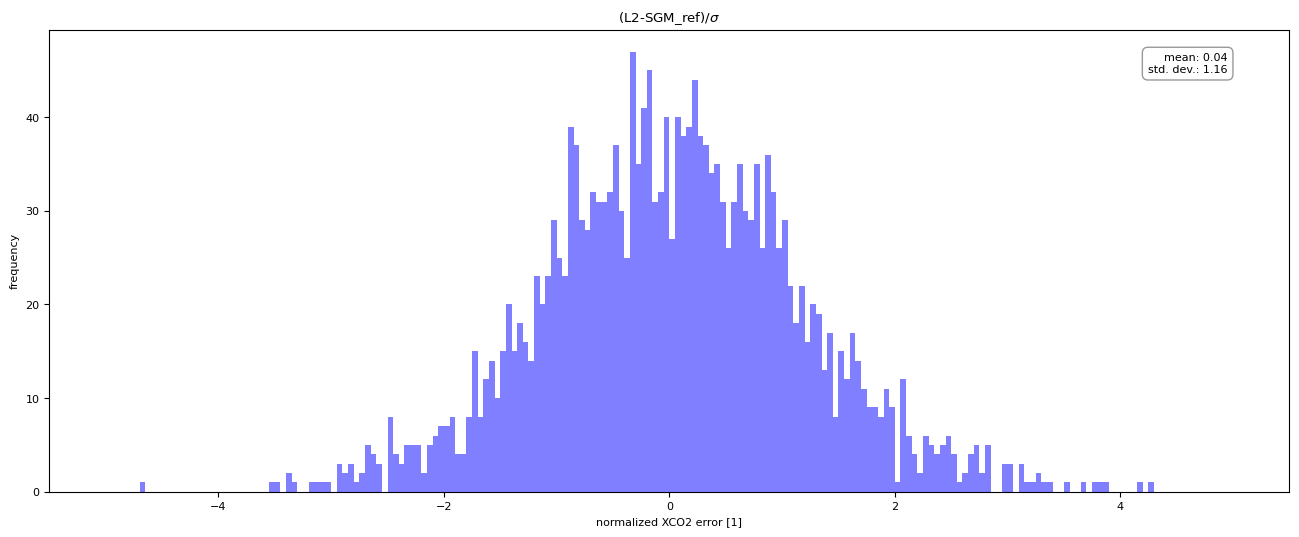

In [8]:
if(pam_l2):
    l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
    sgmrad_config= yaml.safe_load(open('./settings/radsgm_config.yaml'))
    filen = l1bl2_config['io_files']['output_l2']
    filen_ref = sgmrad_config['io_files']['output_geo_ref']
    plt_options ='map'
    plt_options ='histo'
    vscale = [390, 430]
    pam_co2.pam_l2(filen, filen_ref, station_name, plt_options, vscale)
    

## 8. Level-2 to Level-4 Processing

The processor is a simplified inversion to derive emission fluxes from the L2 product assuming perfect knowlegde of the wind field. This tool is usefull to relate the lower level mission performance to L4 performance. 

In [9]:
if(proc_l4):
    l2l4_config= yaml.safe_load(open('./settings/l2l4_config.yaml'))
    l4_product=level2_to_level4_processor(l2l4_config)

[22:58:21] Fitted scaling factor (alpha, XCO2 proxy): 692.673 ± 21.912
[22:58:21] Grouped NetCDF file '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level4/Tango_Carbon_l4_exp1.0.nc' created successfully.
[22:58:21] => Level 2 to Level 4 processing finished successfully


Processing with method: microhh_fit
*************************************************
L4 approach: microhh_fit
true emission:                   732.502 kg/s
estimated emission:              692.673 kg/s
precision of estimated emission: 21.912 kg/s
*************************************************
